<a href="https://colab.research.google.com/github/bariscangungor/blockchain-smart-contract-auditing-using-ml/blob/main/Chaineer_SmartContractAuditingUsingMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prediction for Smart Contract Vulnerabilities Using Machine Learning

## Data Preparation

In [ ]:
# Raw data retrieval code should be placed here !!!

!pip install requests
!pip install pprintjson
!pip install ethereum-etl

import requests
import pprint
import json

module= 'contract'
action = 'getsourcecode'

address = '0xC1dcBB3E385Ef67f2173A375F63f5F4361C4d2f9&apikey=T7T811X7WRD867A71YFDIQY2TRXJ2561NN'

query = f"https://api-ropsten.etherscan.io/api?module={module}&action={action}&address={address}"

# In order for API to allow our request through Google Colab
headers = {'Content-Type' : 'application/json', 'Accept': 'application/json,text/html','user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36 OPR/82.0.4227.43'}

response = requests.get(query, headers=headers)
print(response.content)
pprint.pprint(json.loads(response.content))

# Complete ASAP: !!!!!!! Source code -> byte code -> opcode transition should be complete to enhance the current analysis methods below with new features !!!!!!!!!
# TODO: Inter Event Time !!!
# TODO: Combine behavioural approach (tx-based) with structural approach (smart contract)

!ethereumetl export_blocks_and_transactions --start-block 500000 --end-block 1000000 --blocks-output "sample_data/input_blocks.csv" --transactions-output "sample_data/input_transactions.csv" --provider-uri https://mainnet.infura.io/v3/fa4130d5eef54d8681308e7239020a78

In [ ]:
import csv
import pandas as pd
import numpy as np
import json
import subprocess 
import sys

# retrieved from internet, publicly available data
data = pd.read_csv('sample_data/data.csv')
balances_before = open('sample_data/balances-before.json')
balances_after = open('sample_data/balances-after.json')

before = json.load(balances_before)
after = json.load(balances_after)

attacker_balance_changes = []
victim_balance_changes = []

input_sizes = []
gas_used = []
tx_hashs = []
labels = []

for i in range(0, data.shape[0]):
    labels.append(data.iloc[i]['fuzz_string'].split(',')[-2])
    
    tx_hashs.append(data.iloc[i]['tx_hash'])
    gas_used.append(int(data.iloc[i]['gas_used']))

    attacker_addr = data.iloc[i]['from']
    victim_addr = data.iloc[i]['to']

    victim_balance_changes.append(int(after[victim_addr]) - int(before[victim_addr]))
    attacker_balance_changes.append(int(after[attacker_addr]) - int(before[attacker_addr]))

    index = str(i + 1)

output_df = pd.DataFrame({
    'tx_hash': tx_hashs,
    'gas_used': gas_used,
    'victim_balance_change': victim_balance_changes,
    'attacker_balance_change': attacker_balance_changes,
    'label': labels
})

output_df.to_csv('sample_data/data_processed.csv', index=True)

In [ ]:
# Load the data frame from processed data

import numpy as np
import pandas as pd

# Loading the data (prepared)
df = pd.read_csv('sample_data/data_processed.csv')
display(df)

performanceOfClassifiers = {
    'naiveBayes': {
    },
    'logisticRegression': {
    }, 
    'knn': {
    }, 
    'svm': {
    },
    'randomForest': {
    }, 
    'neuralNetwork': {
    }
}


,Unnamed: 0,tx_hash,gas_used,victim_balance_change,attacker_balance_change,label
0,0,0x3c2d8496c1dd4b51d49b8f22c8c6546622edc5c2e91b...,66939,0,0,safe
1,1,0x9ac733aafba3e2ba4e4a93c2e4d6ff254f09572017a3...,295051,-9500000000000000000,100000000000000000,vul
2,2,0x4831d7bf5e7c1f10ad7cab339dcad3fbf013b0e71fc4...,66939,0,0,safe
3,3,0x6c359158edd12f83071fe3d3e8639bcdc7b76890b386...,102681,-1900000000000000000,20000000000000000,safe
4,4,0x6c359158edd12f83071fe3d3e8639bcdc7b76890b386...,102681,-1900000000000000000,20000000000000000,safe
...,...,...,...,...,...,...
100,100,0xf9fefdc18938cabddd7ba663cf650308eca0c0f2b624...,199205,-3500000000000000000,3500000000000000000,safe
101,101,0xd0d3ffd711a2dfd149c36ae0fde88a83fc77aa695c43...,172953,0,0,safe
102,102,0xc6dec90decdfc2f93c4cc67ecd49db8ace335ba99f4b...,170609,-2500000000000000000,2500000000000000000,safe
103,103,0xd369b1578f34c9a6fe7f9b80e3226f7f49faef57f0d4...,162546,-6000000000000000000,6000000000000000000,vul


## Colleration Matrix (Heatmap)

In [ ]:
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)  

new_df.columns

Index(['gas_used', 'victim_balance_change', 'attacker_balance_change'], dtype='object')

In [ ]:
new_df.victim_balance_change.value_counts()

0                        29
-1500000000000000000      9
-500000000000000000       6
-3000000000000000000      5
-36000000000000000000     5
-6000000000000000000      4
-4500000000000000000      3
-3500000000000000000      3
-1000000000000000000      3
-2500000000000000000      3
-9000000000000000000      2
-21000000000000000000     2
-26000000000000000000     2
-14000000000000000000     2
-15000000000000000000     2
-18000000000000000000     2
-5000000000000000000      2
-1900000000000000000      2
1000000000000000000       2
-10000000000000000000     2
2000000000000000000       1
-49000000000000000000     1
-20000000000000000000     1
-27000000000000000000     1
-4000000000000000000      1
-7500000000000000000      1
-9500000000000000000      1
-63000000000000000000     1
-6100000000000000000      1
-11000000000000000000     1
-25000000000000000000     1
-42000000000000000000     1
-35000000000000000000     1
-199999                   1
-28000000000000000000     1
Name: victim_balance

In [ ]:
# install necessary libraries 
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

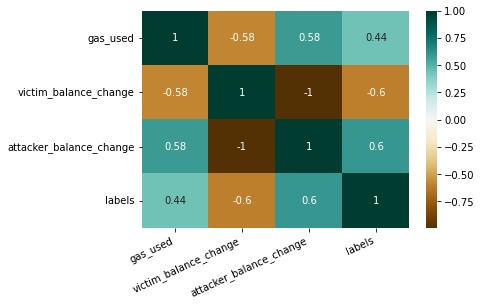

In [ ]:
# Heatmap Correlation Matrix

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

new_df = df.copy()
new_df.drop(columns = ['Unnamed: 0', 'tx_hash'], inplace=True)

new_df['victim_balance_change'] = pd.to_numeric(new_df['victim_balance_change'], errors='coerce')
new_df['attacker_balance_change'] = pd.to_numeric(new_df['attacker_balance_change'], errors='coerce')

labels = list(new_df['label'])
labels_num = list()
for index in range(0, len(labels)):
    if labels[index] == 'safe':
        labels_num.append(0)
    else:
        labels_num.append(1)

new_df['labels'] = pd.to_numeric(labels_num)

corr_matrix = new_df.corr()
matrix = np.triu(new_df.corr())

plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(corr_matrix, annot = True, cbar_kws= {'orientation': 'vertical'}, cmap='BrBG')
plt.xticks(rotation=25, ha='right')

plt.savefig('sample_data/output_heatmap.pdf', dpi=300, bbox_inches='tight')

## Utility Functions

In [ ]:
# Utility functions

# Confusion Matrix Calculation for False Negative & False Positive
def get_errors(y_pred, test_labels):
    fp, fn, tp, tn = 0, 0, 0, 0
    y_pred_list = list(y_pred)

    for i in range(0, len(y_pred_list)):
        if y_pred_list[i] != test_labels[i]:
            if (y_pred_list[i] == "vul" and test_labels[i] == "safe"):
                fp += 1
            if (y_pred_list[i] == 'safe' and test_labels[i] == 'vul'):
                fn += 1
        else:
            if (y_pred_list[i] == 'vul' and test_labels[i] == 'vul'):
                tp += 1
            if (y_pred_list[i] == 'safe' and test_labels[i] == 'safe'):
                tn += 1
                
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)

    return (fnr, fpr)

## Defining & Running The Classifiers

In [ ]:
# import libraries
 
import string 
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix

## Random Forest

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

labels = list(df['label'])
 
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)  

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

kf = StratifiedKFold(n_splits=5, shuffle=True)
 
for train_indices, test_indices in kf.split(X, Y):
    # training
    rf.fit(X[train_indices], Y[train_indices])

    # prediction
    y_pred=rf.predict(X[test_indices])

    print(classification_report(Y[test_indices], y_pred))
    
    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
 
    fn, fp = get_errors(y_pred, Y[test_indices])
    print('false negative is: {0}, false positive is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)
    
    print("\nrandomForest Accuracy of prediction is: {}".format(ac)) 

print("\nrandomForest Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['randomForest']['fp'] = sum(fp_list) / len(fn_list)
performanceOfClassifiers['randomForest']['fn'] = sum(fn_list) / len(fn_list)
performanceOfClassifiers['randomForest']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['randomForest']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['randomForest']['recall'] = sum(recall_list) / len(recall_list)
 
print(performanceOfClassifiers)

              precision    recall  f1-score   support

        safe       1.00      1.00      1.00        12
         vul       1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

false negative is: 0.0, false positive is: 0.0

randomForest Accuracy of prediction is: 1.0
              precision    recall  f1-score   support

        safe       0.85      1.00      0.92        11
         vul       1.00      0.80      0.89        10

    accuracy                           0.90        21
   macro avg       0.92      0.90      0.90        21
weighted avg       0.92      0.90      0.90        21

false negative is: 0.2, false positive is: 0.0

randomForest Accuracy of prediction is: 0.9047619047619048
              precision    recall  f1-score   support

        safe       0.92      1.00      0.96        11
         vul       1.00      0.90     

## Logistic Regression

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

labels = list(df['label'])
 
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True)  

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

kf = StratifiedKFold(n_splits=5, shuffle=True)
 
for train_indices, test_indices in kf.split(X, Y):
    # training
    logreg = LogisticRegression() 
    logreg.fit(X[train_indices], Y[train_indices])

    # prediction
    y_pred=logreg.predict(X[test_indices])

    print(classification_report(Y[test_indices], y_pred))
    
    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
 
    fn, fp = get_errors(y_pred, Y[test_indices])
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)
    
    print("\nnlogisticRegression Accuracy of prediction is: {}".format(ac)) 

 
print("\nlogisticRegression Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['logisticRegression']['fp'] = sum(fp_list) / len(fn_list)
performanceOfClassifiers['logisticRegression']['fn'] = sum(fn_list) / len(fn_list)
performanceOfClassifiers['logisticRegression']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['logisticRegression']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['logisticRegression']['recall'] = sum(recall_list) / len(recall_list)
 
print(performanceOfClassifiers)

              precision    recall  f1-score   support

        safe       0.92      1.00      0.96        12
         vul       1.00      0.89      0.94         9

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

fn is: 0.1111111111111111, fp is: 0.0

nlogisticRegression Accuracy of prediction is: 0.9523809523809523
              precision    recall  f1-score   support

        safe       0.73      1.00      0.85        11
         vul       1.00      0.60      0.75        10

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21

fn is: 0.4, fp is: 0.0

nlogisticRegression Accuracy of prediction is: 0.8095238095238095
              precision    recall  f1-score   support

        safe       0.79      1.00      0.88        11
         vul       1.00      0.70      0.8

## K-NN

In [ ]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

labels = list(df['label'])

new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True) 

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()

kf = StratifiedKFold(n_splits=5, shuffle=True)
 
for train_indices, test_indices in kf.split(X, Y):

    classifier = KNeighborsClassifier(n_neighbors=5)

    # training
    classifier.fit(X[train_indices], Y[train_indices])

    # prediction
    y_pred = classifier.predict(X[test_indices])
    
    print(classification_report(Y[test_indices], y_pred))  

    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)

    test_df = df.loc[test_indices, :].copy()
    test_labels = list(test_df['label'])
 
    fn, fp = get_errors(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)  

    # measuring performance
    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
    
    print("\nKNN Accuracy of prediction is: {}".format(ac))

print("\nKNN Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['knn']['fp'] = sum(fp_list) / len(fp_list)
performanceOfClassifiers['knn']['fn'] = sum(fn_list) / len(fp_list)
performanceOfClassifiers['knn']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['knn']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['knn']['recall'] = sum(recall_list) / len(recall_list)

print(performanceOfClassifiers)

              precision    recall  f1-score   support

        safe       0.92      1.00      0.96        12
         vul       1.00      0.89      0.94         9

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

fn is: 0.1111111111111111, fp is: 0.0

KNN Accuracy of prediction is: 0.9523809523809523
              precision    recall  f1-score   support

        safe       0.79      1.00      0.88        11
         vul       1.00      0.70      0.82        10

    accuracy                           0.86        21
   macro avg       0.89      0.85      0.85        21
weighted avg       0.89      0.86      0.85        21

fn is: 0.3, fp is: 0.0

KNN Accuracy of prediction is: 0.8571428571428571
              precision    recall  f1-score   support

        safe       0.80      0.73      0.76        11
         vul       0.73      0.80      0.76        10

    accuracy       

## Naive Bayes

In [ ]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
 
labels = list(df['label'])

new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True) 

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()
 
kf = StratifiedKFold(n_splits=5, shuffle=True)

for train_indices, test_indices in kf.split(X, Y):

    # Gaussian Naive Bayes classier:
    gnb = GaussianNB()

    # training
    gnb.fit(X[train_indices, :], Y[train_indices])

    # prediction
    y_pred = gnb.predict(X[test_indices])
    print(classification_report(Y[test_indices], y_pred))    

    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
 
    fn, fp = get_errors(y_pred, Y[test_indices])
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)

    # measuring performance
    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
    
    print("\nnaiveBayes Accuracy of prediction is: {}".format(ac)) 
 
print("\nnaiveBayes Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['naiveBayes']['fp'] = sum(fp_list) / len(fp_list)
performanceOfClassifiers['naiveBayes']['fn'] = sum(fn_list) / len(fn_list)
performanceOfClassifiers['naiveBayes']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['naiveBayes']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['naiveBayes']['recall'] = sum(recall_list) / len(recall_list)
 
print(performanceOfClassifiers)

              precision    recall  f1-score   support

        safe       0.80      1.00      0.89        12
         vul       1.00      0.67      0.80         9

    accuracy                           0.86        21
   macro avg       0.90      0.83      0.84        21
weighted avg       0.89      0.86      0.85        21

fn is: 0.3333333333333333, fp is: 0.0

naiveBayes Accuracy of prediction is: 0.8571428571428571
              precision    recall  f1-score   support

        safe       0.77      0.91      0.83        11
         vul       0.88      0.70      0.78        10

    accuracy                           0.81        21
   macro avg       0.82      0.80      0.81        21
weighted avg       0.82      0.81      0.81        21

fn is: 0.3, fp is: 0.09090909090909091

naiveBayes Accuracy of prediction is: 0.8095238095238095
              precision    recall  f1-score   support

        safe       0.89      0.73      0.80        11
         vul       0.75      0.90      0.82 

## SVM

In [ ]:
# SVM Classifier
from sklearn import svm

labels = list(df['label'])
 
new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True) 

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()
 
kf = StratifiedKFold(n_splits=5, shuffle=True)

for train_indices, test_indices in kf.split(X, Y):
    
    train_df = df.loc[train_indices, :].copy()
    test_df = df.loc[test_indices, :].copy()
    
    train_df.drop(columns=['tx_hash'], inplace=True)
    train_df.drop(columns=['Unnamed: 0'], inplace=True)
    
    test_df.drop(columns=['tx_hash'], inplace=True)
    test_df.drop(columns=['Unnamed: 0'], inplace=True)

    train_labels = list(train_df['label'])
    train_df.drop(columns=['label'], inplace=True)

    test_labels = list(test_df['label'])
    test_df.drop(columns=['label'], inplace=True)

    # SVM classier:
    clf = svm.SVC(kernel='linear')

    # training
    clf.fit(X[train_indices, :], Y[train_indices])

    # prediction
    y_pred = clf.predict(X[test_indices, :])
    print(classification_report(Y[test_indices], y_pred))

    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)
 
    fn, fp = get_errors(y_pred, test_labels)
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)

    # measuring performance
    ac = metrics.accuracy_score(test_labels, y_pred)
    accuracies.append(ac)
    
    print("\nSVM Accuracy of prediction is: {}".format(ac)) 

print("\nSVM Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['svm']['fp'] = sum(fp_list) / len(fp_list)
performanceOfClassifiers['svm']['fn'] = sum(fn_list) / len(fn_list)
performanceOfClassifiers['svm']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['svm']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['svm']['recall'] = sum(recall_list) / len(recall_list)
 
print(performanceOfClassifiers)

              precision    recall  f1-score   support

        safe       0.77      0.83      0.80        12
         vul       0.75      0.67      0.71         9

    accuracy                           0.76        21
   macro avg       0.76      0.75      0.75        21
weighted avg       0.76      0.76      0.76        21

fn is: 0.3333333333333333, fp is: 0.16666666666666666

SVM Accuracy of prediction is: 0.7619047619047619
              precision    recall  f1-score   support

        safe       0.91      0.91      0.91        11
         vul       0.90      0.90      0.90        10

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

fn is: 0.1, fp is: 0.09090909090909091

SVM Accuracy of prediction is: 0.9047619047619048
              precision    recall  f1-score   support

        safe       1.00      0.91      0.95        11
         vul       0.91      1.00      0.9

## Neural Network

In [ ]:
# Neural Network Classifier Libraries

!pip install keras


In [ ]:
# Neural Network Classifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

new_df = df.copy()
new_df.drop(columns=["Unnamed: 0"], inplace=True)
new_df.drop(columns=["label"], inplace=True)
new_df.drop(columns=["tx_hash"], inplace=True) 

scaler = StandardScaler()
scaler.fit(new_df)
new_df = scaler.transform(new_df)
 
X = np.copy(new_df)
Y = np.array(list(df['label']))

# encode values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# baseline model
def create_baseline(dimension=3):
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=dimension, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

accuracies = list()
fn_list = list()
fp_list = list()
recall_list = list()
f1_list = list()
 
for train_indices, test_indices in kfold.split(X, Y):

    # training
    estimator.fit(X[train_indices, :], Y[train_indices])

    # prediction
    y_pred = estimator.predict(X[test_indices])
    print(classification_report(Y[test_indices], y_pred))    

    # classification report (cr)
    cr = classification_report(Y[test_indices], y_pred, output_dict=True)
    recall_list.append(cr['vul']['recall'])
    f1_list.append(cr['vul']['f1-score'])

    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
 
    fn, fp = get_errors(y_pred, list(Y[test_indices]))
    print('fn is: {0}, fp is: {1}'.format(fn, fp))
    fp_list.append(fp)
    fn_list.append(fn)

    # measuring performance
    ac = metrics.accuracy_score(Y[test_indices], y_pred)
    accuracies.append(ac)
    
    print("\nneuralNetwork Accuracy of prediction is: {}".format(ac)) 
         
print("\nneuralNetwork Average accuracy: {}".format(sum(accuracies) / len(accuracies)))

performanceOfClassifiers['neuralNetwork']['fp'] = sum(fp_list) / len(fp_list)
performanceOfClassifiers['neuralNetwork']['fn'] = sum(fn_list) / len(fn_list)
performanceOfClassifiers['neuralNetwork']['ac'] = sum(accuracies) / len(accuracies)
performanceOfClassifiers['neuralNetwork']['f1'] = sum(f1_list) / len(f1_list)
performanceOfClassifiers['neuralNetwork']['recall'] = sum(recall_list) / len(recall_list)
 
print(performanceOfClassifiers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


              precision    recall  f1-score   support

        safe       1.00      0.67      0.80         6
         vul       0.71      1.00      0.83         5

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11

fn is: 0.0, fp is: 0.3333333333333333

neuralNetwork Accuracy of prediction is: 0.8181818181818182
              precision    recall  f1-score   support

        safe       0.75      1.00      0.86         6
         vul       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11

fn is: 0.4, fp is: 0.0

neuralNetwork Accuracy of prediction is: 0.8181818181818182
              precision    recall  f1-score   support

        safe       0.71      0.83      0.77         6
         vul       0.75      0.60      0.67         5


## Calculate & Plot the results

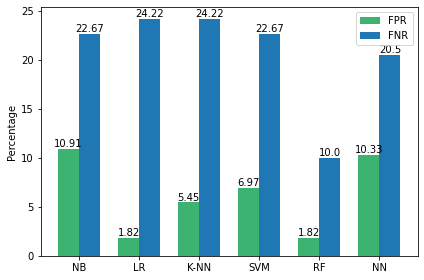

In [ ]:
fp_ = list()
fn_ = list()
f1_ = list()
ac_ = list()
recall_ = list()

for classifier, classifier_dict in performanceOfClassifiers.items():
    fp_.append(round(classifier_dict['fp'] * 100, 2))
    fn_.append(round(classifier_dict['fn'] * 100, 2))
    f1_.append(round(classifier_dict['f1'], 2))
    ac_.append(round(classifier_dict['ac'], 2))
    recall_.append(round(classifier_dict['recall'], 2))

labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fp_, width, label='FPR', color='mediumseagreen')
rects2 = ax.bar(x + width/2, fn_, width, label='FNR')

# Add text for labels (title, x-axis labels, and such)
ax.set_ylabel('Percentage')

# ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.rcParams["figure.figsize"] = (6, 4)
fig.tight_layout()
plt.savefig('sample_data/output_FPR-FNR.pdf')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Unrecognized location 'l'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


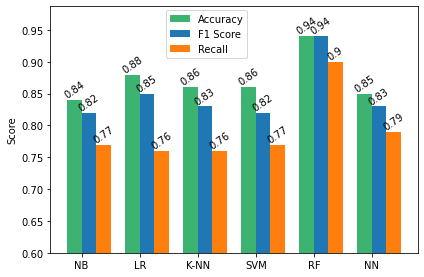

{'naiveBayes': {'fp': 0.1090909090909091, 'fn': 0.22666666666666666, 'ac': 0.838095238095238, 'f1': 0.816034024455077, 'recall': 0.7733333333333332}, 'logisticRegression': {'fp': 0.01818181818181818, 'fn': 0.24222222222222226, 'ac': 0.8761904761904763, 'f1': 0.8479704162366701, 'recall': 0.7577777777777779}, 'knn': {'fp': 0.05454545454545454, 'fn': 0.24222222222222226, 'ac': 0.8571428571428573, 'f1': 0.8330999066293183, 'recall': 0.7577777777777779}, 'svm': {'fp': 0.0696969696969697, 'fn': 0.22666666666666666, 'ac': 0.8571428571428573, 'f1': 0.8227637721755368, 'recall': 0.7733333333333332}, 'randomForest': {'fp': 0.01818181818181818, 'fn': 0.1, 'ac': 0.9428571428571428, 'f1': 0.9367251461988305, 'recall': 0.9}, 'neuralNetwork': {'fp': 0.10333333333333332, 'fn': 0.205, 'ac': 0.8500000000000002, 'f1': 0.8301082251082251, 'recall': 0.7949999999999999}}


In [ ]:
# Ploting the results

labels = ['NB', 'LR', 'K-NN', 'SVM', 'RF', 'NN']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ac_, width, label='Accuracy', color='mediumseagreen')
rects2 = ax.bar(x + width/2, f1_, width, label='F1 Score')
rects3 = ax.bar(x + 3*width/2, recall_, width, label='Recall')

ax.set_ylim(bottom=0.60)

# Add text for labels (title, x-axis labels, and such)
ax.set_ylabel('Score')

# ax.set_title('Number of False Positive and False Negative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=9)
ax.legend(loc='l', bbox_to_anchor=(0.55,0.77))

def autolabel(rects, rect_num=None): 
    for rect in rects:
        height = rect.get_height()
        
        xytext=(0, 0)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xytext,  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=35)

autolabel(rects1)
autolabel(rects2, rect_num=2)
autolabel(rects3)

fig.tight_layout()

plt.savefig('sample_data/output_accuracyF1ScoreRecall.pdf')
plt.show()

print(performanceOfClassifiers)